# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization, 
* model architecture (for deep networks),
* experiment design,
* result analysis

## Deadline

Deadline for this home assignment is February 23th, 2024.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided, 
with execution traces.
This assignment is to be done **by groups of two, at most** and names of both students should be included in the file name.

In [1]:
from tslearn.datasets import UCR_UEA_datasets
from keras.utils import to_categorical

X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
print(X_train.shape)


y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)
print(X_train.shape, y_train.shape, y_train_cat.shape, y_test_cat.shape)

num_categories = y_train_cat.shape[-1]

2024-02-16 20:21:31.474427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 20:21:31.474483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 20:21:31.514586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 20:21:31.594242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 20:21:32.977758: W tensorflow/compiler/tf2

(1000, 128, 1)
(1000, 128, 1) (1000,) (1000, 4) (4000, 4)


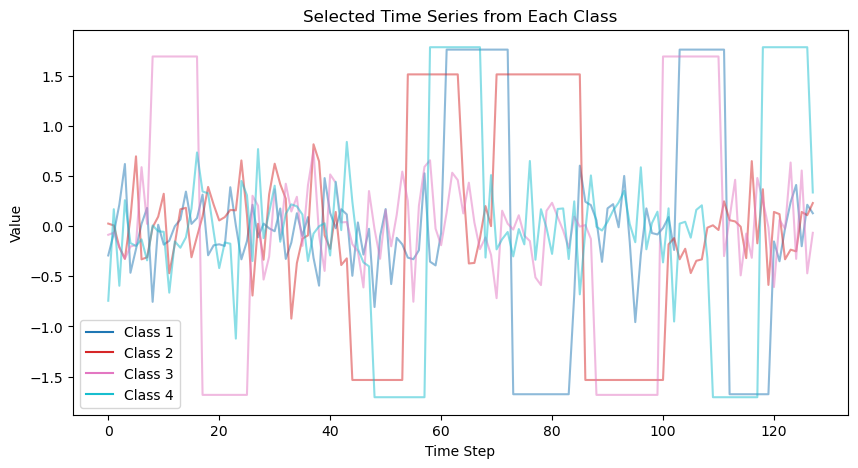

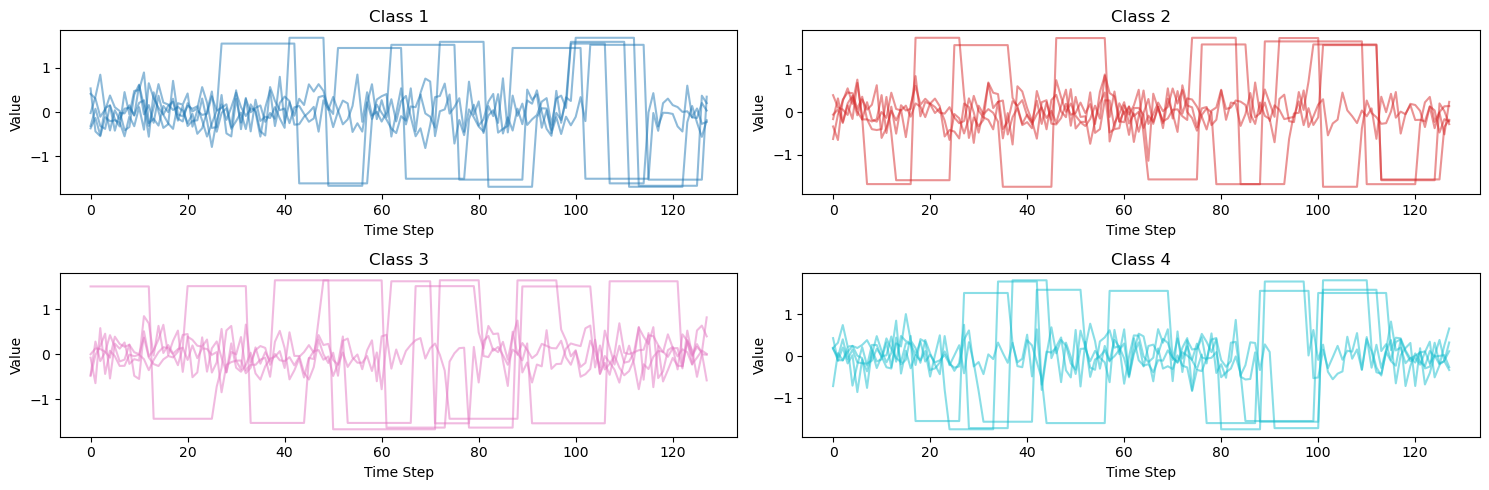

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_classes(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(10, 5))

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Plot all selected samples for this class at once
        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        # Add a legend entry for this class
        ax.plot([], [], color=colors[idx], label=f'Class {cls}')

    ax.legend()
    plt.title('Selected Time Series from Each Class')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()


def plot_selected_classes_subplots(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Calculate the number of rows needed for subplots based on the number of classes
    num_rows = int(np.ceil(num_classes / 2))  # Adjust the denominator to control how many columns you want
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 2.5), squeeze=False)

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Determine which subplot to use
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]

        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        ax.set_title(f'Class {cls}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_selected_classes(X_train, y_train, 1)
plot_selected_classes_subplots(X_train, y_train, 5)

In [3]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tqdm.notebook import tqdm
import multiprocessing

# Function to evaluate clustering quality
def evaluate_clustering(X_train_scaled, params):
    n_clusters = params['n_clusters']
    gamma = params['gamma']
    
    # Fit the model and predict clusters in one step
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma": gamma}, n_jobs=multiprocessing.cpu_count() * 2 // 3, random_state=0)
    y_pred = km.fit_predict(X_train_scaled)

    # Compute the silhouette score
    score = silhouette_score(X_train_scaled, y_pred, metric="softdtw", metric_params={"gamma": gamma})
    
    return {'n_clusters': n_clusters, 'gamma': gamma, 'score': score}


In [4]:
# Preprocess the time series data
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)

sample_size = 50  # Adjust this value to your desired sample size
random_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
X_train_sample = X_train_scaled[random_indices]

# Define parameter grid for grid search
param_grid = [{'n_clusters': n_clusters, 'gamma': gamma} for n_clusters in range(2, 5) for gamma in [0.01, 0.1, 1, 10]]

# Perform grid search with tqdm progress bar using list comprehension
results = [evaluate_clustering(X_train_sample, params) for params in tqdm(param_grid, desc="Grid search progress")]


# Find the best parameters
best_params = max(results, key=lambda x: x['score'])
best_n_clusters = best_params['n_clusters']
best_gamma = best_params['gamma']
best_score = best_params['score']

print(f"Best number of clusters: {best_n_clusters}")
print(f"Best gamma for soft-DTW: {best_gamma}")
print(f"Best silhouette score: {best_score}")

Grid search progress:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
# Fit the final model with the best parameters
final_km = TimeSeriesKMeans(n_clusters=best_n_clusters, 
                            metric="softdtw", 
                            metric_params={"gamma": best_gamma},
                            verbose=1, 
                            random_state=0)
final_km.fit(X_train_sample)

# Plot the barycenters
# plt.figure(figsize=(10, 5))
# for i in range(best_n_clusters):
#     plt.plot(final_km.cluster_centers_[i], label=f'Barycenter {i+1}')
# plt.legend()
# plt.title('Barycenters of the clusters')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.show()

140.292 --> 44.324 --> 44.550 --> 44.792 --> 44.517 --> 44.562 --> 47.025 --> 48.689 --> 48.621 --> 48.641 --> 48.617 --> 48.633 --> 48.620 --> 48.645 --> 48.635 --> 48.651 --> 48.643 --> 48.662 --> 48.652 --> 48.665 --> 48.655 --> 48.664 --> 48.656 --> 48.669 --> 48.661 --> 48.668 --> 48.661 --> 48.671 --> 48.664 --> 48.672 --> 48.665 --> 48.673 --> 48.667 --> 48.674 --> 48.668 --> 48.675 --> 48.669 --> 48.676 --> 48.669 --> 48.676 --> 48.670 --> 48.677 --> 48.671 --> 48.677 --> 48.671 --> 48.678 --> 48.672 --> 48.678 --> 48.672 --> 48.678 --> 


TimeSeriesKMeans(metric='softdtw', metric_params={'gamma': 0.1}, n_clusters=4,
                 random_state=0, verbose=1)

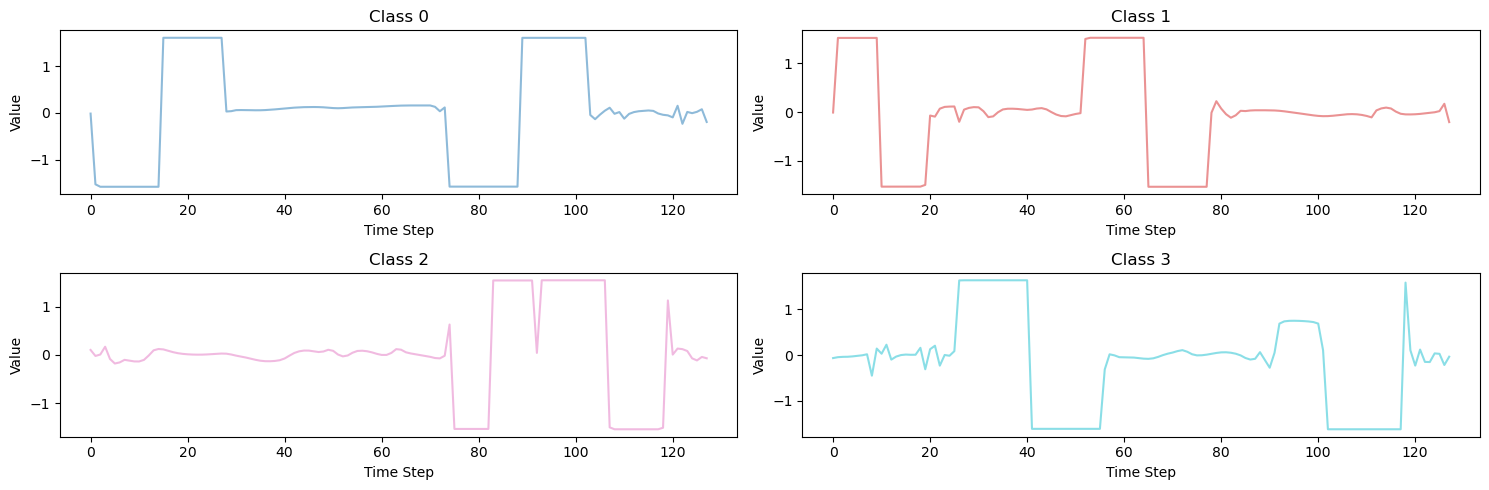

In [20]:
plot_selected_classes_subplots(final_km.cluster_centers_, list(range(final_km.n_clusters)), 1)

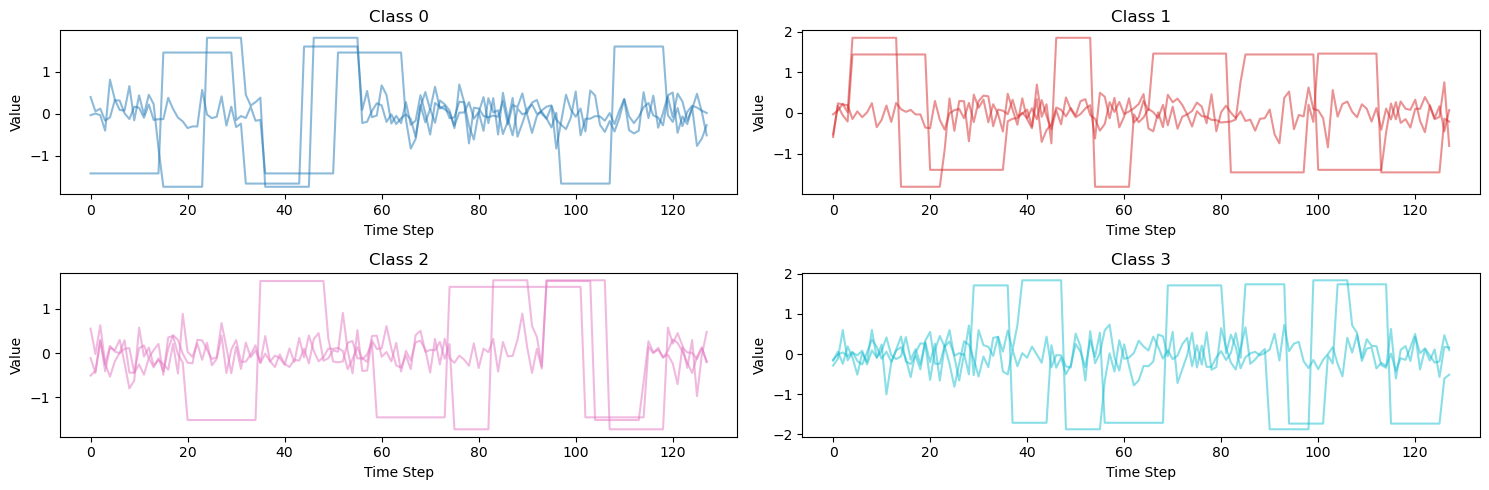

In [21]:
plot_selected_classes_subplots(X_train_sample, final_km.labels_, 3)

In [5]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_cnn_attention_model(input_shape, num_categories, conv_configs, dense_units=50, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for config in conv_configs:
        filters = config['filters']
        kernel_size = config['kernel_size']
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        
        if config.get('attention'):
            # Reshape for attention if necessary. Attention requires the input shape as (batch_size, sequence, features).
            # After Conv1D and Pooling layers, the shape should already be compatible.
            query = value = x
            attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                            key_dim=config['attention']['key_dim'],
                                            dropout=dropout_rate)(query, value, value)
            x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
            x = Dropout(dropout_rate)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
conv_configs = [
    {'filters': 64, 'kernel_size': 3, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 3},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 3, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]

cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs)

cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)

2024-02-16 19:45:58.928720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 19:45:59.062045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 19:45:59.062363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-02-16 19:46:01.971565: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa0280412d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 19:46:01.971593: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-16 19:46:02.101387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-16 19:46:02.945101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3066 - loss: 1.6603

I0000 00:00:1708109170.601926  138448 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.3131 - loss: 1.6038 - val_accuracy: 0.4688 - val_loss: 1.1649
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4964 - loss: 1.1157 - val_accuracy: 0.7570 - val_loss: 0.6803
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8361 - loss: 0.4893 - val_accuracy: 0.9800 - val_loss: 0.0978
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9846 - loss: 0.0750 - val_accuracy: 0.9908 - val_loss: 0.0390
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.0188 - val_accuracy: 0.9945 - val_loss: 0.0223
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0136 - val_accuracy: 0.9975 - val_loss: 0.0095
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0137 - val_accuracy: 0.9952 - val_loss: 0.0183
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9983 - val_loss: 

In [8]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_lstm_attention_model(input_shape, num_categories, lstm_configs, dense_units=50, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for i, config in enumerate(lstm_configs):
        lstm_units = config['units']
        return_sequences = True if i < len(lstm_configs) - 1 else False
        x = LSTM(lstm_units, return_sequences=return_sequences)(x)
        
        if config.get('attention'):
            # Assuming the attention layer is applied after the LSTM layer
            if return_sequences:
                # MultiHeadAttention expects inputs as (batch_size, sequence_length, features),
                # which matches the output shape of LSTM with return_sequences=True
                query = value = x
                attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                                key_dim=config['attention']['key_dim'],
                                                dropout=dropout_rate)(query, value, value)
                x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
                x = Dropout(dropout_rate)(x)
    
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_configs = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  # LSTM layer without attention
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  # LSTM layer followed by attention
]

lstm_attention_model = create_lstm_attention_model(X_train[0].shape, num_categories, lstm_configs)
lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4398 - loss: 1.1422 - val_accuracy: 0.5060 - val_loss: 0.7591
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6168 - loss: 0.7158 - val_accuracy: 0.8075 - val_loss: 0.4924
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8225 - loss: 0.4888 - val_accuracy: 0.8270 - val_loss: 0.4239
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9128 - loss: 0.2696 - val_accuracy: 0.9247 - val_loss: 0.2673
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9743 - loss: 0.1405 - val_accuracy: 0.9852 - val_loss: 0.0715
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9804 - loss: 0.0787 - val_accuracy: 0.9300 - val_loss: 0.1947
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9621 - loss: 0.1330 - val_accuracy: 0.8680 - val_loss: 0.4863
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8691 - loss: 0.3392 - val_accuracy: 0.

In [11]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
import keras

def create_transformer_model(input_shape, num_categories, num_layers=3, d_model=64, num_heads=4, dff=256, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Initial projection of input to the desired dimension (d_model)
    x = Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed-forward network
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
        
    # Pooling layer to reduce the sequence dimension
    pooled_output = GlobalAveragePooling1D()(x)
    
    # Output layer for classification
    outputs = Dense(num_categories, activation='softmax')(pooled_output)
    
    model = Model(inputs, outputs)
    return model

transformer_model = create_transformer_model(X_train[0].shape, num_categories)
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)


Epoch 1/100


KeyboardInterrupt: 

In [2]:
import numpy as np

def prepare_forecasting_data(X, t):
    """
    Prepares training data for forecasting the next 128-t timesteps from the first t timesteps.
    
    Parameters:
    - X: numpy array of shape (n_series, 128, n_features), original dataset.
    - t: int, number of timesteps to use as input.
    
    Returns:
    - X_input: Input data consisting of the first t timesteps from each series.
    - X_target: Target data consisting of the next 128-t timesteps from each series.
    """
    # Number of timesteps to predict
    output_length = 128 - t
    
    # Input sequences: first t timesteps
    X_input = X[:, :t, :]
    
    # Target sequences: next 128-t timesteps
    X_target = X[:, t:, :]
    
    return X_input, X_target

# Example usage
t = 64  # Number of timesteps given as input
X_train_input, X_train_target = prepare_forecasting_data(X_train, t)
X_test_input, X_test_target = prepare_forecasting_data(X_test, t)

print("Training input shape:", X_train_input.shape)
print("Training target shape:", X_train_target.shape)
print("Testing input shape:", X_test_input.shape)
print("Testing target shape:", X_test_target.shape)


Training input shape: (1000, 64, 1)
Training target shape: (1000, 64, 1)
Testing input shape: (4000, 64, 1)
Testing target shape: (4000, 64, 1)


In [5]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

def create_forecasting_lstm_model(input_shape, output_length):
    inputs = Input(shape=input_shape)
    # Encoder
    encoded = LSTM(128, return_sequences=False)(inputs)
    # Repeat the encoding for each time step
    repeated_encoding = RepeatVector(output_length)(encoded)
    # Decoder
    decoded = LSTM(128, return_sequences=True)(repeated_encoding)
    # TimeDistributed layer for output
    outputs = TimeDistributed(Dense(1))(decoded)
    
    model = Model(inputs, outputs)
    return model

# Example usage
t = 64  # Let's say we're given the first 64 steps and need to predict the next 64
input_shape = (t, 1)  # Assuming the input shape is (timesteps, features)
output_length = 128 - t  # We need to predict the next 128-t steps
forecasting_lstm_model = create_forecasting_lstm_model(input_shape, output_length)
forecasting_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_lstm_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=10)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2085 - mae: 0.8724 - val_loss: 0.7730 - val_mae: 0.6322
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1675 - mae: 0.8594 - val_loss: 0.7682 - val_mae: 0.6266
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1444 - mae: 0.8482 - val_loss: 0.7849 - val_mae: 0.6403
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1490 - mae: 0.8512 - val_loss: 0.7762 - val_mae: 0.6315
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1261 - mae: 0.8357 - val_loss: 0.7918 - val_mae: 0.6415
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1412 - mae: 0.8445 - val_loss: 0.7671 - val_mae: 0.6270
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1144 - mae: 0.8269 - val_loss: 0.7665 - val_mae: 0.6254
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1259 - mae: 0.8357 - val_loss: 0.7663 - val_mae: 0.6267
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.105

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D

def create_forecasting_transformer_model(input_shape, num_layers, d_model, num_heads, dff, output_length, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    # Adapt the Transformer to output a sequence of the desired length
    x = Dense(output_length)(x)
    outputs = Dense(1)(x)  # Assuming a single feature per timestep in the output
    
    model = Model(inputs, outputs)
    return model

# Example usage for the Transformer model

# Example usage
t = 64  # Let's say we're given the first 64 steps and need to predict the next 64
input_shape = (t, 1)  # Assuming the input shape is (timesteps, features)
output_length = 128 - t  # We need to predict the next 128-t steps
forecasting_transformer_model = create_forecasting_transformer_model(
    input_shape=(t, 1),
    num_layers=3,
    d_model=64,
    num_heads=4,
    dff=256,
    output_length=output_length,
    dropout_rate=0.1
)
forecasting_transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_transformer_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=10)

Epoch 1/10


2024-02-16 20:25:38.013785: I external/local_xla/xla/service/service.cc:168] XLA service 0x56485ef21db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 20:25:38.013823: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-16 20:25:38.193101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2672 - mae: 1.4612

I0000 00:00:1708111554.043253    3625 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 683ms/step - loss: 2.6484 - mae: 1.2979 - val_loss: 0.7513 - val_mae: 0.6171
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2508 - mae: 0.8939 - val_loss: 0.7465 - val_mae: 0.6155
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2279 - mae: 0.8839 - val_loss: 0.7463 - val_mae: 0.6140
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2346 - mae: 0.8888 - val_loss: 0.7459 - val_mae: 0.6143
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1921 - mae: 0.8631 - val_loss: 0.7465 - val_mae: 0.6139
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2270 - mae: 0.8811 - val_loss: 0.7456 - val_mae: 0.6144
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2178 - mae: 0.8780 - val_loss: 0.7460 - val_mae: 0.6143
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2366 - mae: 0.8869 - val_loss: 0.7460 - val_mae: 0.6139
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2313 - mae: 